<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.4%20Interest%20Rates/Section%202.4.1.4%20Testing%20for%20Independence%20in%20the%20Direction%20of%20Changes%20of%20Interest%20Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Initializing...")
#print("Installing arch...")
#!pip install arch 1>/dev/null
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from datetime import datetime
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

Initializing...


In [13]:
# get the bill rate data from Fred
DTB3=pd.read_table('https://fred.stlouisfed.org/data/DTB3.txt',skiprows=11,sep=r'\s+',header=0).rename(columns={"VALUE":"Rate","DATE":"Date"}).set_index("Date")
DTB3.index=pd.DatetimeIndex(DTB3.index).to_period('D')
DTB3['Rate']=DTB3['Rate'].apply(lambda x:float(x) if x!='.' else np.nan)

# join the recessions data (NBER data at Fred) 
USREC=pd.read_table('https://fred.stlouisfed.org/data/USREC.txt',skiprows=65,sep=r'\s+',header=0).rename(columns={"VALUE":"Recession","DATE":"Date"}).set_index("Date")
USREC.index=pd.DatetimeIndex(USREC.index).to_period('D')
DTB3=DTB3.merge(USREC,left_index=True,right_index=True,how='outer')
DTB3['Recession'].ffill(inplace=True)
DTB3['Recession']=DTB3['Recession'].apply(lambda x:True if x else False)
DTB3.dropna(inplace=True)
DTB3['Year']=DTB3.index.year
DTB3.index=pd.DatetimeIndex(DTB3.index.to_timestamp()).to_period('B') # business days

# enrich the data frame
DTB3['Change']=DTB3['Rate']-DTB3['Rate'].shift().ffill() # changes that skip over holidays, why is this so hard?
DTB3['PriorChange']=DTB3["Change"].shift().ffill()
DTB3.dropna(inplace=True)
DTB3['SignChange']=DTB3['Change'].apply(lambda x:"Up" if x>zero else "Down" if x<zero else "No Change")
DTB3['SignPriorChange']=DTB3['PriorChange'].apply(lambda x:"Up" if x>zero else "Down" if x<zero else "No Change")
display(DTB3)

,Rate,Recession,Year,Change,PriorChange,SignChange,SignPriorChange
Date,,,,,,,
1954-01-06,1.28,True,1954,0.00,-0.05,No Change,Down
1954-01-07,1.31,True,1954,0.03,0.00,Up,No Change
1954-01-08,1.31,True,1954,0.00,0.03,No Change,Up
1954-01-11,1.33,True,1954,0.02,0.00,Up,No Change
1954-01-12,1.30,True,1954,-0.03,0.02,Down,Up
...,...,...,...,...,...,...,...
2023-03-29,4.64,False,2023,0.00,-0.11,No Change,Down
2023-03-30,4.80,False,2023,0.16,0.00,Up,No Change
2023-03-31,4.68,False,2023,-0.12,0.16,Down,Up


  0%|          | 0/69 [00:00<?, ?it/s]

,chi^2,Sample,p Value
year,,,
1954,16.789889,248.0,2.260070e-04
1955,10.653881,251.0,4.858912e-03
1956,15.495023,252.0,4.318158e-04
1957,13.651791,254.0,1.085303e-03
1958,11.252704,249.0,3.601691e-03
...,...,...,...
2018,1.121248,249.0,5.708529e-01
2019,6.548870,250.0,3.783825e-02
2020,4.874133,251.0,8.741691e-02


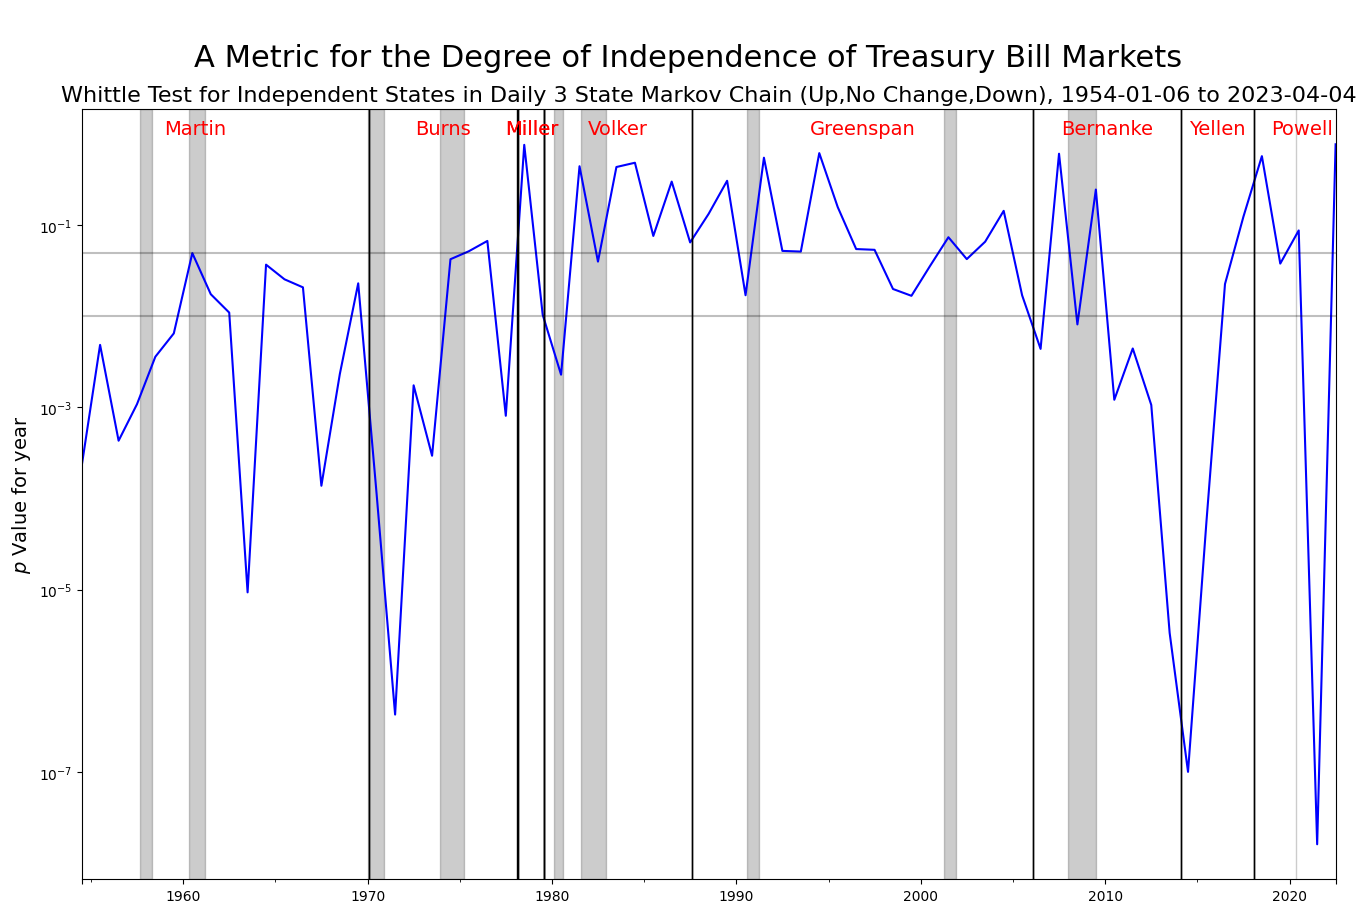

In [72]:
# compute the contingency matrix
from scipy.stats import chi2
from tqdm.notebook import tqdm

# Whittle test year-by-year
results=pd.DataFrame({"year":[],"chi^2":[],"Sample":[],"p Value":[]}).set_index("year")
results.index=pd.DatetimeIndex(results.index).to_period('Y')

for year in tqdm(range(DTB3.index[0].year,DTB3.index[-1].year)):
    # get crosstab with margins
    ct=pd.crosstab(DTB3.loc[DTB3.index.year==year,'SignChange'],DTB3.loc[DTB3.index.year==year,'SignPriorChange'],margins=True)    

    # compute Whittle statistic
    ws=zero

    for i in range(ct.shape[0]):
        for j in range(ct.shape[1]):
            ws+=((ct.iloc[i,j]-ct.iloc[i,-1]*ct.iloc[j,-1]/(ct.iloc[-1,-1]-one))**2)/(ct.iloc[i,-1]*ct.iloc[j,-1]/(ct.iloc[-1,-1]-one))

    results.loc[year,'chi^2']=ws
    results.loc[year,'Sample']=ct.iloc[-1,-1]
    results.loc[year,'p Value']=one-chi2.cdf(ws,len(ct)-2)

display(results)

# Figure 2.21
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nA Metric for the Degree of Independence of Treasury Bill Markets",fontsize=22)
plot.set_title("Whittle Test for Independent States in Daily 3 State Markov Chain (Up,No Change,Down), %s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=16)
results.index=pd.DatetimeIndex(map(lambda x:datetime(x,6,30),results.index)).to_period('B')
results['p Value'].plot(ax=plot,color='blue')

recbe=list(DTB3.index[DTB3['Recession']!=DTB3['Recession'].shift()])

for b,e in [(k.asfreq(*'MS'),v.asfreq(*'ME')) for k,v in zip(recbe[:-2:2],recbe[1::2])]:
    plot.axvspan(b.to_timestamp(),e.to_timestamp(),color='black',alpha=0.2)

plot.axvspan(recbe[-1].asfreq(*'MS').to_timestamp(),recbe[-1].asfreq(*'ME').to_timestamp(),color='black',alpha=0.2) # above construct doesn't get the COVID recession

for c,b,e in ('Martin','1951-04-02','1970-01-31'),('Burns','1970-02-01','1978-01-31'),('Miller','1978-03-08','1979-08-06'),\
             ('Miller','1978-03-08','1979-08-06'),('Volker','1979-08-06','1987-08-11'),('Greenspan','1987-08-11','2006-01-31'),\
             ('Bernanke','2006-02-01','2014-01-31'),('Yellen','2014-02-03','2018-02-3'),('Powell','2018-02-05',datetime.now()):        
    plot.axvline(b,color='black',lw=1)
    plot.axvline(e,color='black',lw=1)
    m=pd.Timestamp(b)+pd.Timedelta(days=(pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    if m<DTB3.index[0].to_timestamp():
        b=DTB3.index[0].to_timestamp()
        m=pd.Timestamp(b)+pd.Timedelta((pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    elif m>DTB3.index[-1].to_timestamp():
        b=DTB3.index[-1].to_timestamp()
        m=pd.Timestamp(b)+pd.Timedelta((pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    plot.text(m,one,c,fontsize=14,horizontalalignment='center',color='red')

plot.set_yscale('log')
plot.axhline(0.05,color='black',alpha=0.25)
plot.axhline(0.01,color='black',alpha=0.25)
plot.set_ylabel('$p$ Value for year',fontsize=14)
plot.set_xlabel(None);

In [64]:
ct


SignPriorChange,Down,No Change,Up,All
SignChange,,,,
Down,36,11,50,97
No Change,12,4,15,31
Up,48,16,57,121
All,96,31,122,249
